<div class="alert alert-block alert-warning">
<b>Costs:</b> This QPU simulation costs [???] dollars.
</div>

<div class="alert alert-block alert-success">
<b>This simulation estimates pi value using monte carlo. </b>
<div>Obs. 1: The data is saved in external files so that it can be worked on without incurring new costs.</div>
<div>Obs. 2: For new simulation parameters, save in a file with a different name.</div>
</div>

# Instructions if you are running outside AWS cloud

1. Install aws-cli:

`sudo apt install aws-cli`

2. Setup aws credentials:

`aws configure --profile "default"`

3. Create virtual environment 

`python -m venv /path/to/new/virtual/environment`

4. Activate virtual environment

`source /path/to/new/virtual/environment/bin/activate`

In [ ]:
# Install all required modules on your virtual environment
!pip install requirements.txt

# Iniciando sessão remota na AWS cloud

In [19]:
from boto3 import Session
from braket.aws import AwsSession

# Start Boto3 Session with your credentials profile
boto_session = Session(profile_name='default')

# Initialize Braket session with Boto3 Session credentials
aws_session = AwsSession(boto_session=boto_session)

# Importando Backends - Computadores Quânticos

In [20]:
from braket.aws import AwsDevice

# Recupera os dispositivos disponíveis
devices = AwsDevice.get_devices()

print("Dispositivos disponíveis na AWS Braket:")
for idx, device in enumerate(devices):
    print(f"{idx}: Nome: {device.name}, Tipo: {device.type}, ARN: {device.arn}")

Dispositivos disponíveis na AWS Braket:
0: Nome: Ankaa-2, Tipo: AwsDeviceType.QPU, ARN: arn:aws:braket:us-west-1::device/qpu/rigetti/Ankaa-2
1: Nome: Aquila, Tipo: AwsDeviceType.QPU, ARN: arn:aws:braket:us-east-1::device/qpu/quera/Aquila
2: Nome: Aria 1, Tipo: AwsDeviceType.QPU, ARN: arn:aws:braket:us-east-1::device/qpu/ionq/Aria-1
3: Nome: Aria 2, Tipo: AwsDeviceType.QPU, ARN: arn:aws:braket:us-east-1::device/qpu/ionq/Aria-2
4: Nome: Forte 1, Tipo: AwsDeviceType.QPU, ARN: arn:aws:braket:us-east-1::device/qpu/ionq/Forte-1
5: Nome: Garnet, Tipo: AwsDeviceType.QPU, ARN: arn:aws:braket:eu-north-1::device/qpu/iqm/Garnet
6: Nome: SV1, Tipo: AwsDeviceType.SIMULATOR, ARN: arn:aws:braket:::device/quantum-simulator/amazon/sv1
7: Nome: TN1, Tipo: AwsDeviceType.SIMULATOR, ARN: arn:aws:braket:::device/quantum-simulator/amazon/tn1
8: Nome: dm1, Tipo: AwsDeviceType.SIMULATOR, ARN: arn:aws:braket:::device/quantum-simulator/amazon/dm1


In [21]:
# Selecionar um dispositivo pelo índice da lista
device_index = int(input("Selecione o índice do dispositivo desejado: "))
selected_device = devices[device_index]

print(f"Dispositivo selecionado: {selected_device.name}, ARN: {selected_device.arn}")

Selecione o índice do dispositivo desejado:  6


Dispositivo selecionado: SV1, ARN: arn:aws:braket:::device/quantum-simulator/amazon/sv1


In [65]:
import math

def calcular_qubits(pontos):
    # Calcular o número mínimo de qubits necessários
    qubits = math.ceil(math.log2(pontos))
    return qubits

# Pedir ao usuário o número de pontos desejados
pontos_desejados = int(input("Digite o número de pontos desejados na simulação: "))
qubits_necessarios = calcular_qubits(pontos_desejados)

# Mostrar o resultado
print(f"Para gerar {pontos_desejados} pontos, você precisará de {qubits_necessarios} qubits.")


Digite o número de pontos desejados na simulação:  1000


Para gerar 1000 pontos, você precisará de 10 qubits.


In [68]:
from braket.aws import AwsDevice
from braket.circuits import Circuit
import time

# Selecionar o dispositivo (exemplo: simulador SV1)
device = selected_device

# Criar o circuito quântico com 20 qubits

circuit = Circuit()
num_qubits = qubits_necessarios

# Aplicar portas Hadamard para criar uma superposição em todos os 20 qubits
for i in range(num_qubits):
    circuit.h(i)

# Medir todos os 20 qubits
for i in range(num_qubits):
    circuit.measure(i)

# Enviar o circuito para o dispositivo
shots = 100  # Número de execuções
# Enviar o circuito para execução no dispositivo
print("Enviando o circuito para o dispositivo...")
task = device.run(circuit, shots=shots)

# Obter o ARN da tarefa
task_arn = task.id
print(f"ARN da tarefa enviada: {task_arn}")

# Monitorar o estado da tarefa
print("Monitorando o estado da tarefa...")
while True:
    status = task.state()
    print(f"Estado atual: {status}")
    if status == "COMPLETED":
        print("A tarefa foi concluída!")
        break
    elif status == "FAILED":
        print("A tarefa falhou.")
        break
    time.sleep(5)  # Aguarda 5 segundos antes de verificar novamente

# Recuperar os resultados após a conclusão
if status == "COMPLETED":
    result = task.result()
    #print("Resultados das medições:", result.measurement_counts)
    
resultados = result.measurement_counts
numero_pontos = len(resultados)
print(numero_pontos)

Enviando o circuito para o dispositivo...
ARN da tarefa enviada: arn:aws:braket:us-east-1:709381776175:quantum-task/a49bd798-4a08-4ea3-8779-0b86fa872971
Monitorando o estado da tarefa...
Estado atual: QUEUED
Estado atual: COMPLETED
A tarefa foi concluída!
92


Total de bitstrings únicas processadas: 92
Estimativa de π: 2.8260869565217392


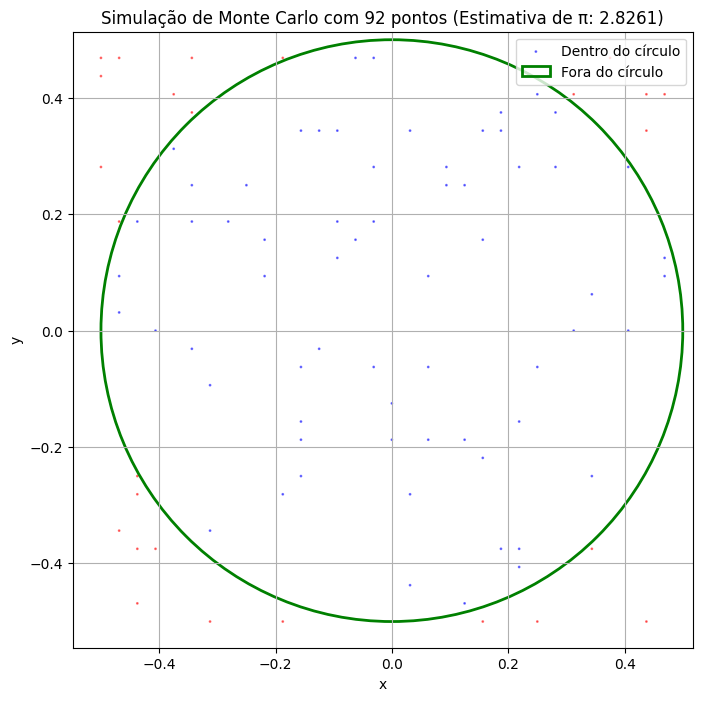

In [69]:
import matplotlib.pyplot as plt

# Inicializar listas para armazenar pontos
x_points = []
y_points = []
colors = []  # Para armazenar as cores dos pontos
inside_circle = 0

# Criar um conjunto para rastrear bitstrings únicas
unique_bitstrings = set()

# Processar as medições
for outcome, count in result.measurement_counts.items():
    # Garantir que cada bitstring seja processada apenas uma vez
    if outcome not in unique_bitstrings:
        unique_bitstrings.add(outcome)

        # Dividir bitstring em x e y
        mid_point = num_qubits // 2
        x_bits = outcome[:mid_point]
        y_bits = outcome[mid_point:]

        # Converter bits para valores entre -0.5 e 0.5
        x = int(x_bits, 2) / (2 ** mid_point) - 0.5
        y = int(y_bits, 2) / (2 ** mid_point) - 0.5
        r_squared = x**2 + y**2

        # Verificar se o ponto está dentro do círculo
        if r_squared <= 0.25:  # Raio do círculo é 0.5
            inside_circle += 1
            colors.append("blue")  # Dentro do círculo
        else:
            colors.append("red")  # Fora do círculo

        # Armazenar os pontos para o gráfico
        x_points.append(x)
        y_points.append(y)

# Exibir número de bitstrings únicas processadas
print(f"Total de bitstrings únicas processadas: {len(unique_bitstrings)}")

numero_pontos = len(unique_bitstrings)

# Calcular π
pi_estimate = 4 * (inside_circle / (numero_pontos))
print(f"Estimativa de π: {pi_estimate}")

# Criar o gráfico
plt.figure(figsize=(8, 8))
plt.scatter(x_points, y_points, c=colors, s=1, alpha=0.5, label="Pontos simulados")
circle = plt.Circle((0, 0), 0.5, color="green", fill=False, linewidth=2, label="Círculo de raio 0.5")
plt.gca().add_artist(circle)

# # Ajustar limites para mostrar todo o círculo
# plt.xlim(-0.6, 0.6)
# plt.ylim(-0.6, 0.6)

# Configurações do gráfico

plt.title(f"Simulação de Monte Carlo com {numero_pontos} pontos (Estimativa de π: {pi_estimate:.4f})")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.legend(["Dentro do círculo", "Fora do círculo", "Círculo de raio 0.5"], loc="upper right")
plt.grid(True)

# Mostrar o gráfico
plt.show()